# Monte Carlo Simulation for Option Pricing and Extentions

I would reccomend running the entire notebook which should take about 2 minutes

### Monte Carlo Simulation Theory (Binomial Model)

Monte Carlo simulations aim to approximate the expectation of a random variable by taking samples paths of an underlying stochastic process and averaging the result. While the convergence is slow $O(n^{-1/2})$, Monte Carlo methods have an advantage over other methods (Trapezoid Approximation) in higher dimensions.
  
First, we will examine Monte Carlo methods for the binomial tree model for simplicity.

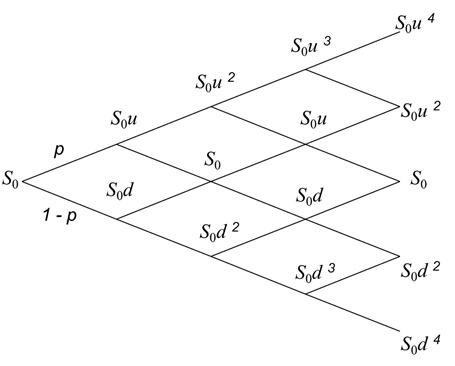

In the binomial tree model, the stock either goes up or down in each of N periods. The probability of going up is called the "risk neutral probability" and is defined as: 
   
$p*=\frac{1+r-d}{u-d}$
  
The advantage of the Monte Carlo method in this context is that we need not perform calculations regarding the $2^N$ different paths, which is important when N is larger than say 10. Instead, we use random sampling of the possible paths and take the average of the payoffs.

#### Simulation of Vanilla Call Option

Here we will determine the Monte Carlo price of a vanilla call option with payoff $(S_T-K)$:

Average payoff: 2.52


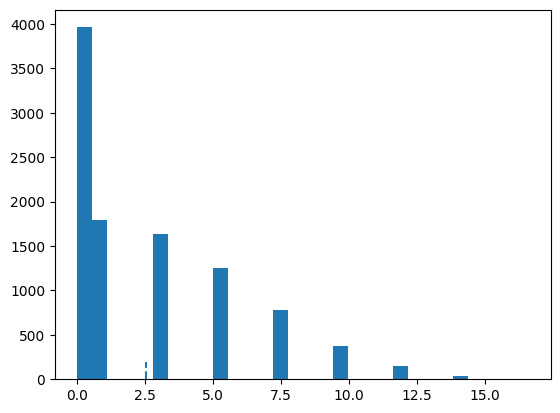

In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
np.random.seed(10)

# Define constants
S0 = 100 # Initial stock price
u = 1.01 # Up factor
d = .99 # Down factor
r = .002 # Risk free rate of return
N = 20 # Number of periods
K = 103 # Strike price
n = 10000 # Number of simulations

# Risk neutral probability
q = (1 + r - d) / (u - d)


def vanilla_call(n,N,q,S0,u,d):
    S_T = np.zeros(n)

    for i in range(n):
        nh = binom.rvs(N, q)
        S_T[i] = S0 * (u/d)**nh * d**N

    payoff = np.maximum(S_T - K,0)

    return payoff


pff = vanilla_call(n,N,q,S0,u,d)

C_0_average = np.mean(pff).round(2)

print(f"Average payoff: {C_0_average}")

plt.hist(pff, bins=30)
plt.vlines(C_0_average,0,200, ls='--')
plt.show()

#### Monte Carlo Error

We can also create a confidence interval for our estimate:

In [2]:
CI_lower = C_0_average - 1.96*np.std(pff)/np.sqrt(n)
CI_upper = C_0_average + 1.96*np.std(pff)/np.sqrt(n)
print(f"[{round(CI_lower,2)}, {round(CI_upper,2)}]")

[2.46, 2.58]


Clearly, there is high uncertainty for our estimate. Ideally, we would like to know the price to the cent (at least). Lets try increasing the number of simulations:

In [3]:
np.random.seed(10)

n_large = 1000000
pff_large_n = vanilla_call(n_large,N,q,S0,u,d)

C_0_average = np.mean(pff_large_n).round(2)

print(f"Average payoff: {C_0_average}")
CI_lower = C_0_average - 1.96*np.std(pff_large_n)/np.sqrt(n_large)
CI_upper = C_0_average + 1.96*np.std(pff_large_n)/np.sqrt(n_large)
print(f"[{round(CI_lower,2)}, {round(CI_upper,2)}]")

Average payoff: 2.42
[2.41, 2.43]


We were able to reduce the uncertainty in our approximation, but computation time was increased significantly (remember $O(n^{-1/2})$ convergence rate).

Lets examine how the solution converges on a moderate simulation size (n=1000):

True Price: 2.33


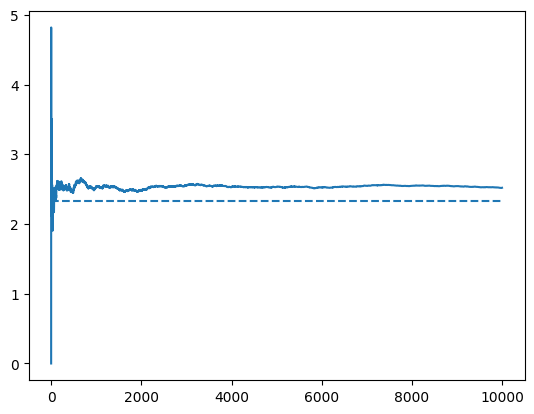

In [4]:
truePrice = 0
for i in range(N):
    S = S0*(u/d)**(i)*d**N
    truePrice += np.maximum(S-K,0) * binom.pmf(i,N,q) / (1+r)**N

print(f"True Price: {round(truePrice,2)}")

pff_cumsum = np.cumsum(pff) / range(1,n+1)
plt.plot(range(n), pff_cumsum)
plt.hlines(truePrice,0,n, ls='--')
plt.show()

### Monte Carlo Theory (BS, no path)

Now, we seek to estimate E[$V_o$] with Black Scholes dynamics of an underlying stock, S:  
  
$S_T = S_0*exp((r-\sigma^2/2)*T + \sigma*\sqrt{T}*Z)$
  
This definition of $S_T$ is based on the risk free probability **Q** and r (risk free rate of return) rather than **P** and $\alpha$. The simulation involves drawing n samples of a standard normal distribution (Z) which are used to determine the terminal price of the stock, as well as the option payoff ($max(S_T-K,0)$) for that result.  

### Simulation (BS, no path)

While not useful in the context of vanilla options, since we have a closed-form solution to the Black Scholes model, it will be used to demonstrate how the process works in a continuous context.

Estimate: 10.67
STDev: 0.15
CI: [10.38, 10.96]
Error: -0.22


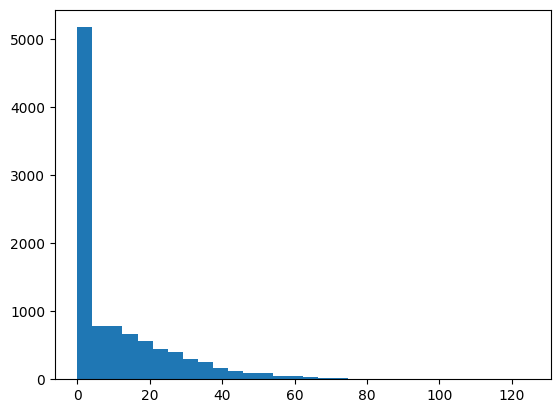

In [5]:
import numpy as np
from numpy import exp, sqrt, log
from scipy.stats import norm
import matplotlib.pyplot as plt
np.random.seed(20)

# Define constants
S0 = 100
T = 1
r = .05
sigma = .2
K = 100

# Sample Standard Normal (Z) for n paths
n = 10000
Z = norm.rvs(size=n)

# Convert samples to terminal prices of the stock at T
S_T = S0 * exp( 
    (r - sigma**2/2)*T + sigma*sqrt(T)*Z 
    )

# Convert terminal prices to option payoff
C_T_payoff = exp(-r*T) * np.maximum(S_T - K, 0)

# Determine average call payoff
C_T_bar = 1/n*np.sum(C_T_payoff)

# Create a confidence interval
C_T_lower = C_T_bar - 1.96 * np.std(C_T_payoff) / n**.5
C_T_higher = C_T_bar + 1.96 * np.std(C_T_payoff) / n**.5
print(f"Estimate: {round(C_T_bar,2)}")
print(f"STDev: {round(np.std(C_T_payoff)/sqrt(n),2)}")
print(f"CI: [{round(C_T_lower,2)}, {round(C_T_higher,2)}]")

# Compare to known value from BS formula
C_BS = S0 * norm.cdf(
    (log(S0/K) + (r+.5*sigma**2*T)) / (sigma*sqrt(T))
) - K * exp(-r*T) * norm.cdf(
    (log(S0/K) + (r-.5*sigma**2*T)) / (sigma*sqrt(T))
)

print(f"Error: {round(C_BS - C_T_bar,2)}")

plt.hist(C_T_payoff, bins = 30)
plt.show()

### Monte Carlo Theory (BS, path dependent)

At this point, we split our time interval (T) into m intervals and simulate the stock price at each point in the interval:  
  
$S(t_{j+1}) = S(t_j)*exp((r-\sigma^2/2)*\Delta t + \sigma*\sqrt{\Delta t}*Z_j)$
  
Now we must sample the standard normal n*m times since we need one for each step of each path. The purpose of this method is so that we know full path of each simulation instead of just the terminal value. This allows us to value more complex options.

### Simulation (BS, Asian)

We will now simulate an Asian-type option with payoff:
  
$(\bar{S} - K)^+$

This is when Monte Carlo becomes especially useful since it can determine the full path of a simulation iteration.  

Estimate: 4.41
CI: [3.95, 4.87]


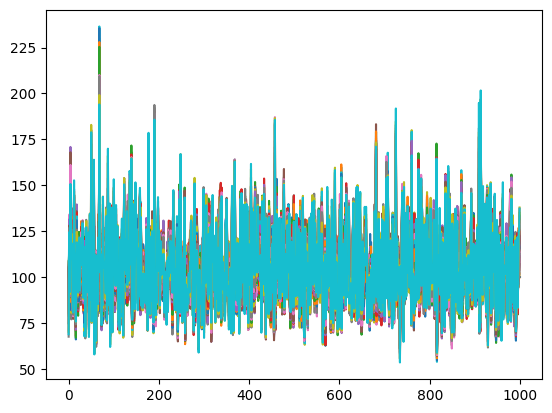

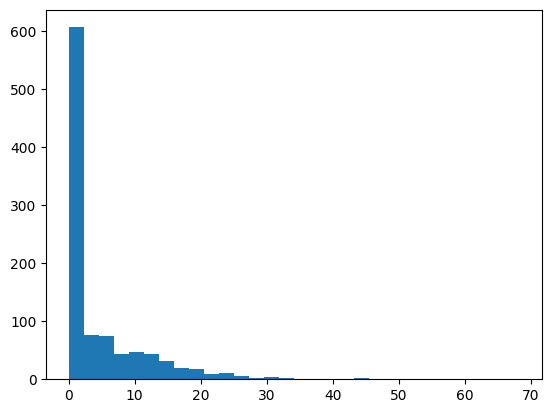

In [6]:
import numpy as np
from numpy import exp, sqrt, log
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set Seed
np.random.seed(10)

# Define constants
S0 = 100
T = 1
r = .05
sigma = .2
K = 103

n = 1000 # Number of simulations
m = 50 # Number of steps per simulation
S = np.zeros((n,m)) # Store each simulation path and step
S[:, 0] = S0 # Initialize each simulation at S0
dt = T/m # Define step-size

# For each step in a single simulation
for j in range(1,m):
    Z_j = norm.rvs(size=n)
    S[:,j] = S[:, j-1] * exp( (r - .5*sigma**2)*dt + sigma*sqrt(dt)*Z_j)

# Determine the average stock value for each path
S_bar = 1/m * np.sum(S, axis=1)

# Determine the option payoff for each path
C_simulations = exp(-r*T) * np.maximum(S_bar - K, 0)

# Determine the average option payoff for n simulations
C_bar = np.mean(C_simulations)
C_T_lower = C_bar - 1.96 * np.std(C_simulations) / n**.5
C_T_higher = C_bar + 1.96 * np.std(C_simulations) / n**.5
print(f"Estimate: {round(C_bar,2)}")
print(f"CI: [{round(C_T_lower,2)}, {round(C_T_higher,2)}]")

plt.plot(S)
plt.show()

plt.hist(C_simulations, bins=30)
plt.show()

## Improving Monte Carlo

To reduce the variance of our estimate, and increse accuracy, Monte Carlo simulations requires a large number of simulations and thus computation. There are many methods to reduce the variance without increasing the number of simulations which will now examine.

### Analysis: Random Samples are not so "Uniform"

To understand the weakness of using random numbers, we will examine a two dimensional plot of randomly generated uniform variables. Notice how much of the sample space is not represented, while some parts are overrepresented

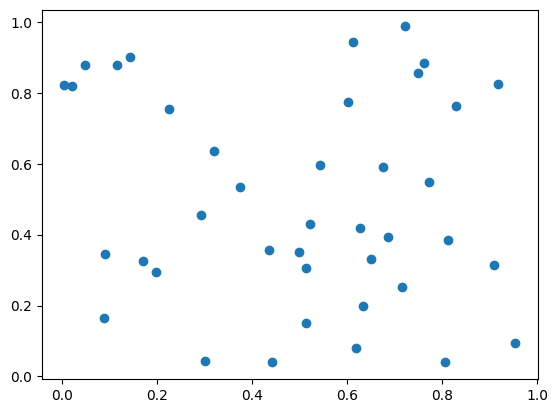

In [7]:
from scipy.stats import uniform
import matplotlib.pyplot as plt
np.random.seed(10)

x = uniform.rvs(size=40)
y = uniform.rvs(size=40)

plt.scatter(x,y)
plt.show()

### Solution: Antithetic MC

One method to reduce the variance of Monte Carlo simulations is to use the "anthithic" result of every random sample we take. In practice, this means for one random sample of the standard normal distribution, we create two simulations. One uses $Z_i$ while the other uses $-Z_i$. Here is an example using the uniform distribution:

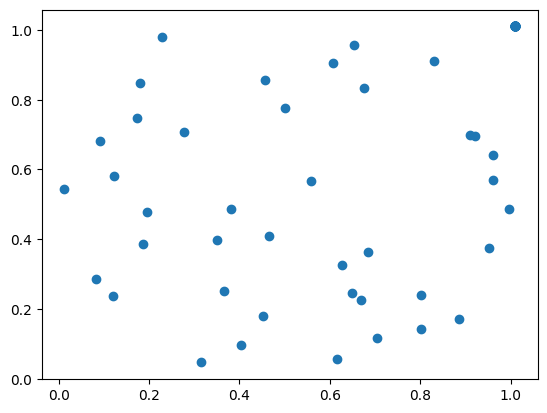

In [8]:
from scipy.stats import uniform
import matplotlib.pyplot as plt
np.random.seed(10)

n = 40

x = np.zeros(2*n)
y = np.zeros(2*n)

for i in range(n):
    ux = uniform.rvs()
    uy = uniform.rvs()
    x[i] = u
    x[i+n] = 1-ux
    y[i] = u
    y[i+n] = 1-uy

plt.scatter(x,y)
plt.show()

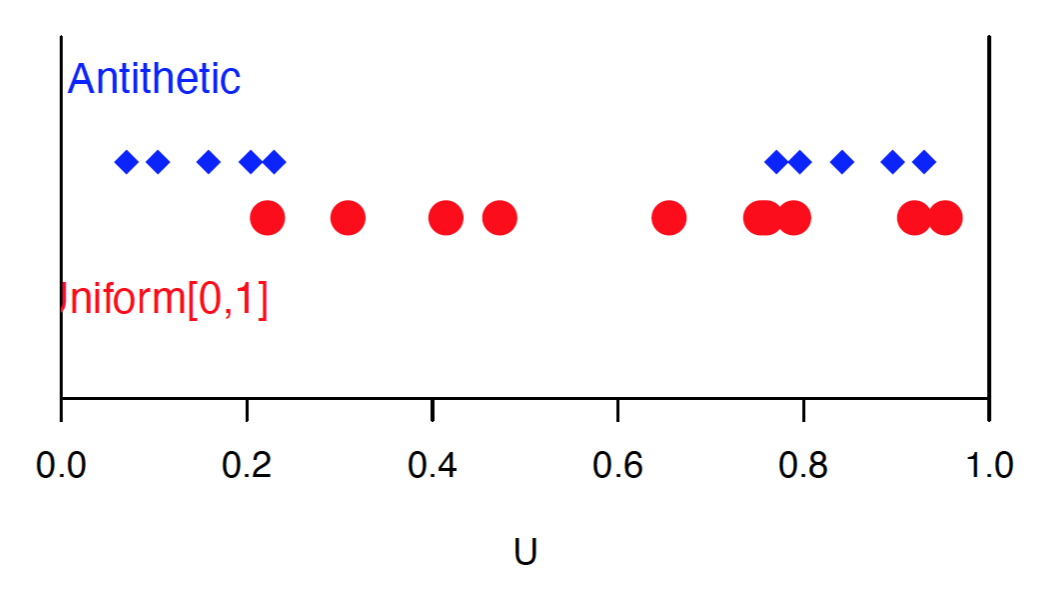

The idea is to increase the "spread" of our samples. While this example does not display that, it showcases the concept.

In [9]:
import numpy as np
from numpy import exp, sqrt, log
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
np.random.seed(20)

# Define constants
S0 = 100
T = 1
r = .05
sigma = .2
K = 100

# Sample Standard Normal (Z) for n paths
n = 10000

S_T = np.zeros(2*n)
C_T_bar = np.zeros(100)

for j in range(100):
    for i in range(n):
        Z = norm.rvs()
        S_T[i] = S0 * exp((r - .5*sigma**2)*T + sigma*sqrt(T)*Z)
        S_T[i+n] = S0 * exp((r - .5*sigma**2)*T - sigma*sqrt(T)*Z) # Notice the minus sign here

    # Convert terminal prices to option payoff
    C_T_payoff = exp(-r*T) * np.maximum(S_T - K, 0)

    # Determine average call payoff
    C_T_bar[j] = np.mean(C_T_payoff)

print(f"True Value: {round(C_BS,3)}")
print(f"Estimate: {C_T_bar.mean().round(3)}")
print(f"STDev: {np.std(C_T_bar).round(3)}")

True Value: 10.451
Estimate: 10.456
STDev: 0.072


In [10]:
np.random.seed(20)
S_T = np.zeros(n)
C_T_bar = np.zeros(100)

for j in range(100):
    for i in range(n):
        Z = norm.rvs()
        S_T[i] = S0 * exp((r - .5*sigma**2)*T + sigma*sqrt(T)*Z)

    # Convert terminal prices to option payoff
    C_T_payoff = exp(-r*T) * np.maximum(S_T - K, 0)

    # Determine average call payoff
    C_T_bar[j] = np.mean(C_T_payoff)

print(f"True Value: {round(C_BS,3)}")
print(f"Estimate: {C_T_bar.mean().round(3)}")
print(f"STDev: {np.std(C_T_bar).round(3)}")

True Value: 10.451
Estimate: 10.473
STDev: 0.159


### Stratified MC

Although we expect a simulated distributuion to match the theoretical distribution as n gets large, we can also ensure the match using stratified sampling. The idea is to partition the distribution's sample space into K strata, and take $n_k$ samples from each strata. In proportional sampling, $n_k=np_i$ where $p_i=P(Y\epsilon A_k)$ and $A_k$ represents an individual partition.
  
For the uniform distribution, we our partition is:
  
$(0,\frac{1}{K}], (\frac{1}{K},\frac{2}{K}], ... , (\frac{K-1}{K}, 1)$
  
and we would draw n/K samples from each partition. The situation is more complex if we seek to simulate a brownian motion for path dependent options. We maintain the same stock price dynamics equation:
  
$S_k(t_i)=S_k(t_{i-1})*exp((r-\sigma^2/2)\Delta t + \sigma (W_k(t_i) - W_k(t_{i-1}))$
  
where $W_k(t_i)$ is now defined as:
  
$W_k(t_i)=\frac{t_M-t_j}{t_M-t_{j-1}}W_k(t_{i-1})+\frac{t_j-t_{j-1}}{t_M-t_{j-1}}W_k(t_M)+\sqrt{\frac{(t_M-t_j)(t_j-t_{j-1})}{t_M-t_{j-1}}}Z_{k,i}$
  
This is a Brownian Bridge, and the stratification part comes from first defining the terminal point ($t_M$) of each of the N simulations:
  
$W_k(t_M)=\sqrt{t_M}\Phi^{-1}(\frac{k-1-U_k}{K})$
  
where $U_k$ is is a uniform random variable drawn from the interval $[\frac{1}{k-1}, \frac{1}{k})$

#### Path Indendent Case

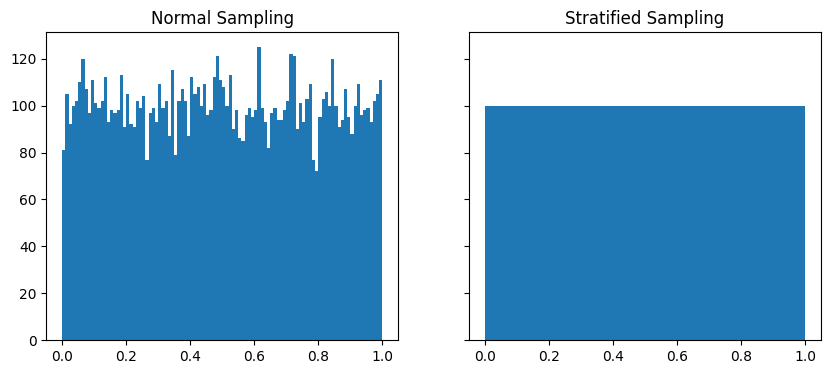

In [11]:
from scipy.stats import uniform
np.random.seed(20)
n = 10000
k = 100

U = np.zeros(n)

# Stratify the uniform dist as described above
for x in range(K):
    U[int(n*x/k):int(n*(x+1)/k)] =  uniform.rvs(x/k, 1/k,  size=int(n/K))

# Compare to normal sampling method
U_ = uniform.rvs(size=n)

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax[0].hist(U_, bins=np.linspace(0,1,101))
ax[0].set_title('Normal Sampling')
ax[1].hist(U, bins=np.linspace(0,1,101))
ax[1].set_title('Stratified Sampling')
plt.show()

In [12]:
S = np.zeros(n)

for i in range(n):
    Z = norm.ppf(U[i])
    S[i] = S0 * exp(
        (r - sigma**2/2)*T + sigma*sqrt(T)*Z
    )

payoff = exp(-r*T) * np.maximum(S - K, 0)
price = np.mean(payoff)

print(f"Estimate: {round(price,3)}")
print(f"STDev: {round(np.std(payoff)/n**.5,3)}")
print(f"Error: {round(C_BS - price,3)}")

Estimate: 10.452
STDev: 0.147
Error: -0.001


#### Path Dependent Case

In [26]:
from scipy.stats import norm
np.random.seed(20)

k = 1000
T = 1
M = 50 # Steps per path
W_M = np.zeros(k) # Terminal BM value
W = np.zeros((k,M)) # Array to hold BM for each step (M) of each path (k)
S = np.zeros((k,M)) # Array to hold stock price for each step (M) of each path (k)
payoff = np.zeros(k)

S[:,0] = S0 # Set S0 as starting price for each path
dt = T/M

# Determine terminal price of each partition/path
for i in range(k):
    W_M[i] = sqrt(T) * norm.ppf(
        (i + U[i]) / k
    )

    for j in range(1,M):
        Z = norm.rvs()
        W[i,j] = (T - T*j/M) / (T - T*(j-1)/M) * W[i,j-1] + (
                (T/M)/(T - T*(j-1)/M)) * W_M[i] + (
                    sqrt( (T - T*j/M)*(T/M) / (T - T*(j-1)/M))  * Z)
        
        S[i,j] = S[i,j-1] * exp(
            (r - sigma**2/2)*dt + sigma*(W[i,j] - W[i,j-1])
        )

S_bar = np.mean(S, axis=1)
payoff = exp(-r*T) * np.maximum(S_bar - K,0)

price = np.mean(payoff)
print(round(price,3))

5.656


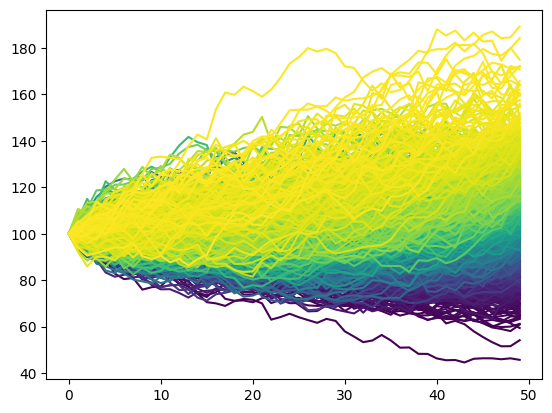

In [28]:
for i in range(S.shape[0]):
    plt.plot(S[i,:], color=plt.cm.viridis(i/S.shape[0]))
plt.show()

### Quasi MC

In [15]:
from scipy.stats.qmc import Sobol
import warnings
warnings.filterwarnings('ignore')

U_sobol = Sobol(1, scramble=True).random(n)
S = np.zeros(n)

for i in range(n):
    Z = norm.ppf(U_sobol[i])
    S[i] = S0 * exp(
        (r - sigma**2/2)*T + sigma*sqrt(T)*Z
    )

payoff = exp(-r*T) * np.maximum(S - K, 0)
price = np.mean(payoff)

print(f"Estimate: {round(price,3)}")
print(f"STDev: {round(np.std(payoff)/n**.5,3)}")
print(f"Error: {round(C_BS - price,3)}")

Estimate: 10.453
STDev: 0.147
Error: -0.002


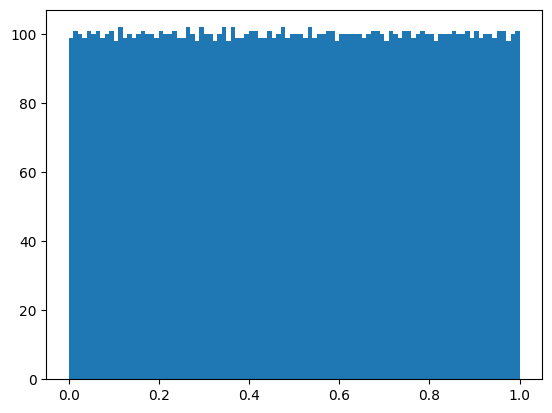

In [16]:
plt.hist(U_sobol, bins = np.linspace(0,1,101))
plt.show()